In [2]:
# Colab에서 구글 드라이브 mount하기
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# 파일 확인하기
!ls "/content/drive/MyDrive/ml-100k"

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [3]:
# 필요한 모듈 import 하기
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
# pandas를 이용하여 파일 불러오기
train = pd.read_csv("/content/drive/MyDrive/ml-100k/ua.base",
                    sep="\t", names=['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv("/content/drive/MyDrive/ml-100k/ua.test",
                    sep="\t", names=['user', 'movie', 'rating', 'timestamp'])

train

,user,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


In [12]:
# pytorch tensor 데이터로 변환
items = torch.tensor(train['movie'], dtype=torch.long)
users = torch.tensor(train['user'], dtype=torch.long)
ratings = torch.tensor(train['rating'], dtype=torch.float)
items_test = torch.tensor(test['movie'], dtype=torch.long)
users_test = torch.tensor(test['user'], dtype=torch.long)
ratings_test = torch.tensor(test['rating'], dtype=torch.float)

In [13]:
rank = 10 # 사용자 vector, 아이템 vector의 차원

numItems = items.max() + 1 # 사용자 수
numUsers = users.max() + 1 # 아이템 수

P = torch.randn(numItems, rank, requires_grad=True) # 아이템 매트릭스
Q = torch.randn(numUsers, rank, requires_grad=True) # 사용자 매트릭스

In [14]:
# 기본 Matrix Factorization 구현
optim = torch.optim.Adam([P, Q], lr=0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):
  h = torch.sum(P[items] * Q[users], dim=1)
  cost = F.mse_loss(h, ratings)

  optim.zero_grad()
  cost.backward()
  optim.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(cost.item())

    h_test = (P[items_test] * Q[users_test]).sum(dim=1)
    cost_test = F.mse_loss(h_test, ratings_test)
    Y_test.append(cost_test.item())

    if epoch % 100 == 0:
      print(f"eopch: {epoch}, cost: {cost.item():.6f}, test_cost: {cost_test.item()}")

eopch: 0, cost: 24.327293, test_cost: 22.64885902404785
eopch: 100, cost: 0.575251, test_cost: 1.5870660543441772
eopch: 200, cost: 0.494760, test_cost: 1.8832876682281494
eopch: 300, cost: 0.470535, test_cost: 2.2167093753814697
eopch: 400, cost: 0.459569, test_cost: 2.5994937419891357
eopch: 500, cost: 0.453637, test_cost: 2.977935552597046
eopch: 600, cost: 0.450099, test_cost: 3.371009111404419
eopch: 700, cost: 0.447869, test_cost: 3.7774627208709717
eopch: 800, cost: 0.446183, test_cost: 4.18400239944458
eopch: 900, cost: 0.444696, test_cost: 4.568434715270996
eopch: 1000, cost: 0.443482, test_cost: 4.965164661407471


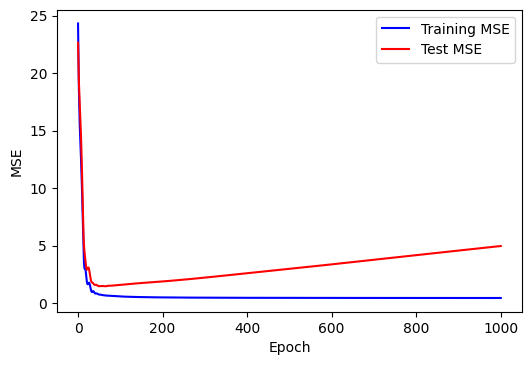

In [16]:
plt.figure(dpi=100)
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X, Y, c="blue", label="Training MSE")
plt.plot(X, Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

eopch: 0, cost: 23.450569, test_cost: 21.407791137695312
eopch: 100, cost: 0.652325, test_cost: 1.02053701877594
eopch: 200, cost: 0.603505, test_cost: 1.0171828269958496
eopch: 300, cost: 0.595277, test_cost: 1.0221362113952637
eopch: 400, cost: 0.592059, test_cost: 1.0225189924240112
eopch: 500, cost: 0.590022, test_cost: 1.0205137729644775
eopch: 600, cost: 0.588786, test_cost: 1.0189852714538574
eopch: 700, cost: 0.588154, test_cost: 1.0177277326583862
eopch: 800, cost: 0.587862, test_cost: 1.0166311264038086
eopch: 900, cost: 0.587723, test_cost: 1.015733242034912
eopch: 1000, cost: 0.587640, test_cost: 1.0150490999221802


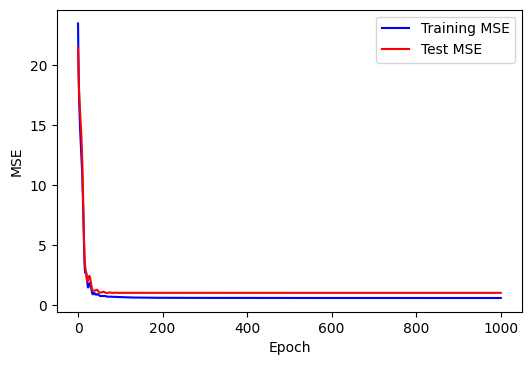

In [26]:
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

# Regularization 추가하기
lambda1 = 1
lambda2 = 1

optim = torch.optim.Adam([P, Q], lr=0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):
  h = torch.sum(P[items] * Q[users], dim=1)
  cost = F.mse_loss(h, ratings)
  loss = cost + lambda1 * (P * P).mean() + lambda2 * (Q * Q).mean()

  optim.zero_grad()
  loss.backward()
  optim.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(cost.item())

    h_test = (P[items_test] * Q[users_test]).sum(dim=1)
    cost_test = F.mse_loss(h_test, ratings_test)
    Y_test.append(cost_test.item())

    if epoch % 100 == 0:
      print(f"eopch: {epoch}, cost: {cost.item():.6f}, test_cost: {cost_test.item()}")
  
plt.figure(dpi=100)
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X, Y, c="blue", label="Training MSE")
plt.plot(X, Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

eopch: 0, cost: 13.892470, test_cost: 10.895406723022461
eopch: 100, cost: 0.610665, test_cost: 0.9340285062789917
eopch: 200, cost: 0.578251, test_cost: 0.9163210988044739
eopch: 300, cost: 0.574502, test_cost: 0.9094997048377991
eopch: 400, cost: 0.573509, test_cost: 0.905746579170227
eopch: 500, cost: 0.572798, test_cost: 0.9041678309440613
eopch: 600, cost: 0.572051, test_cost: 0.905362606048584
eopch: 700, cost: 0.571123, test_cost: 0.9090666174888611
eopch: 800, cost: 0.570765, test_cost: 0.9096581339836121
eopch: 900, cost: 0.570676, test_cost: 0.9085574746131897
eopch: 1000, cost: 0.570642, test_cost: 0.9073695540428162


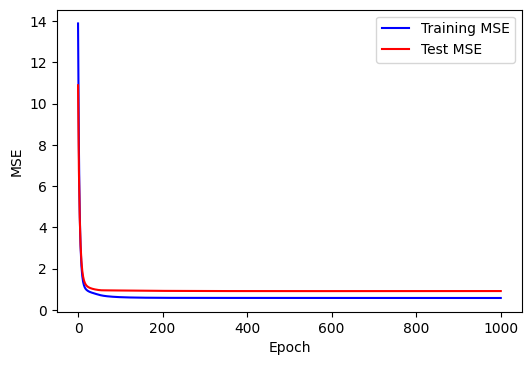

In [28]:
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

# Bias 추가하기
lambda1 = 1
lambda2 = 1
lambda3 = 1
lambda4 = 1

bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = ratings.mean()

optim = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.1)

X = []
Y = []
Y_test = []
for epoch in range(1001):
  h = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  cost = F.mse_loss(h, ratings)
  loss = cost + lambda1 * (P * P).mean() + lambda2 * (Q * Q).mean() + \
      lambda3 * (bias_user ** 2).mean() + lambda4 * (bias_item ** 2).mean()

  optim.zero_grad()
  loss.backward()
  optim.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(cost.item())

    h_test = (P[items_test] * Q[users_test]).sum(dim=1) + \
        mean + bias_item[items_test] + bias_user[users_test]
    cost_test = F.mse_loss(h_test, ratings_test)
    Y_test.append(cost_test.item())

    if epoch % 100 == 0:
      print(f"eopch: {epoch}, cost: {cost.item():.6f}, test_cost: {cost_test.item()}")

plt.figure(dpi=100)
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X, Y, c="blue", label="Training MSE")
plt.plot(X, Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()